# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, regcm4, wrf, maps, CNN, sdsm, kddm, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename

### Load model output data

In [5]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load UATM data

In [6]:
# # need this for ires the first time
# d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
# mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))


In [7]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))



In [8]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    #d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    #d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [9]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == 5 and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Plot routines

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

# plot average rain inputs
def plot_8v_clim(isample, modelname, vmin, vmax):
#     varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
#     units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
#     cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
#     fig, axarr = plt.subplots(1, 8, figsize = (20,20))
#     for ii in range(8):
#         plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[ii])
#         axarr[ii].set_title(varmames[ii])
#     plt.suptitle(modelname, y=0.29, fontsize=16)
#     plt.show()
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

    

    # ALL Ranges centered on zero for U, V
    for ii in range(8):
        vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
        vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))


          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()


def plot_8v_autoscale(isample, modelname):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    
    # autoscale
    vmin = [isample[ii].min() for ii in range(8)]
    vmax = [isample[ii].max() for ii in range(8)]

#     # Use 0 as minimum value for Q
#     vmin[2] = 0. 

    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()


In [14]:
from os.path import basename

def plot_models(sigfiles):     
#     # find min/max values for entire sigfiles set
#     vmin = 9999*np.ones(8) 
#     vmax = -9999*np.ones(8) 
#     for sigfile in sigfiles:        
#         if sigfile.lower().find('hist') >= 0: 
#             load_uatm_mpi_hist()
#         elif sigfile.lower().find('rcp85') >= 0: 
#             load_uatm_mpi_future()
#         else:
#             print ("ERROR: neither hist or rcp85 found")
#         rainsignal = xr.open_dataset(sigfile)['prec']
#         avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal) 
#         vmin = [min(avginput[ii].min(),vmin[ii]) for ii in range(8)]
#         vmax = [max(avginput[ii].max(),vmax[ii]) for ii in range(8)]
    
#     # Use 0 as minimum value for Q
#     vmin[2] = 0. 

#     # Ranges centered on zero for U, V
#     vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
#     vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
#     vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
#     vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
#     vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
#     vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
#     vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
#     vmax[7] = max(abs(vmin[7]), abs(vmax[7]))


    # plots 
    for sigfile in sigfiles:
        if sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
            
        # calc average dry, moist, wet
        rainsignal = xr.open_dataset(sigfile)['prec']
        sigfilename = basename(sigfile)
        dryinput, drycount, drydistribution, dryindices = calc_uatm_average(0, 0.254, rainsignal, -9999, 9999) 
        moistinput, moistcount, moistdistribution, moistindices = calc_uatm_average(0.254, 3.0, rainsignal, -9999, 9999) 
        wetinput, wetcount, wetdistribution, wetindices = calc_uatm_average(3.0, 9999.0, rainsignal, -9999, 9999) 

        # plot clim
        print ("days:", drycount, moistcount, wetcount, ", model:", sigfilename)
#         plot_8v_autoscale(dryinput-allinput, 'Dry Climatology')
#         plot_8v_autoscale(moistinput-allinput, 'Moist Climatology')
#         plot_8v_autoscale(wetinput-allinput, 'Wet Climatology')
        plot_8v_clim(dryinput-allinput, 'Dry Climatology', vmin, vmax)
        plot_8v_clim(moistinput-allinput, 'Moist Climatology', vmin, vmax)
        plot_8v_clim(wetinput-allinput, 'Wet Climatology', vmin, vmax)
        
        print('_'*80)
        print('\n')



#         # plot
#         rainsignal = xr.open_dataset(sigfile)['prec']
#         avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal) 
#         sigfilename = basename(sigfile)
#         print ("days:", count, ", model:", sigfilename)
#         rowtitle = '.'.join(sigfilename.split('.')[0:4])
#         plot_8v(avginput, rowtitle.upper(), vmin, vmax)

In [15]:
# MOVE INTO PLOT SECTION
# POSTAGE STAMP LAYOUT
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from os.path import basename
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import ticker

import warnings
warnings.filterwarnings("ignore")

   


def plot_models_group_drymoistwet(sigfiles, vmin, vmax, mpr_min, mpr_max, title):     
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['PiYG', 'PuOr', 'cubehelix_r', 'inferno', 'terrain', 'Spectral', 'brg', 'PuOr'] #ABS
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']  # CLIM

    
    # CLIM
    # ALL Ranges centered on zero for U, V
    for ii in range(8):
        vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
        vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))

    # ABS
#     # Ranges centered on zero for U, V
#     vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
#     vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
#     vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
#     vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
#     # Q850 cubehelix_r, 0:maximum
#     vmin[2] = 0
    
#     # U250 brg, 0:max
#     vmin[6] = 0
    
#     # V250 PuOr, symmetric around zero
#     vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
#     vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

    
    #fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (10,10*(3/8.+0.0)), gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.3]})
    fig, axarr = plt.subplots(nrows=len(sigfiles), ncols=8, figsize = (20,20*(len(sigfiles)/8.+0.0)), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1]*(len(sigfiles)-1)+[1.313]})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    
    # plots 
    #for sigfile in sigfiles:
    #for jj, mpr_min, mpr_max, label in [[0, 0., 0.254, 'Dry'], [1, 0.254, 3., 'Moist'], [2, 3., 9999., 'Wet']]:
    #mpr_min, mpr_max = [0., 0.254]
    for jj in range(len(sigfiles)):

        # get jjth sigfile
        sigfile = sigfiles[jj]
        
        # row label
        sigfilename = basename(sigfile)
        #print ("days:", count, ", model:", sigfilename)
        label = ' '.join(sigfilename.split('.')[3:4])


        
        # load UATM and signal file
        if sigfile.lower().find('obs') >= 0:
            load_uatm_erai()
        elif sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
        rainsignal = xr.open_dataset(sigfile)['prec']

        # plot
        counts = [0]*len(sigfiles)
                
        # calc avg atm for criteria
        avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal, -9999, 9999) 
        
        # subtract clim
        #if sigfile.lower().find('obs') >= 0:
        #    avginput-=era_allinput  # era
        #else:
        #    avginput-=allinput  # mpi
        avginput-=era_allinput  # era

        
        # use percentages intead of counts (2021-10-26)
        #counts[jj] = count
        allavginput, allcount, alldistribution, allindices = calc_uatm_average(0, 9999, rainsignal, -9999, 9999) 
        counts[jj] = count/allcount

        for ii in range(8):
            axarr[jj,ii].coastlines()
            axarr[jj,ii].add_feature(cfeature.STATES)
            img_extent = (lon.min(), lon.max(), lat.min(), lat.max())

            #plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
            plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  

            # show y tics on first column
            if ii==0:
                axarr[jj,ii].get_yaxis().set_visible(True)
                axarr[jj,ii].tick_params(labelsize='xx-small')

                # We need to draw the canvas, otherwise the labels won't be positioned and 
                # won't have values yet.
                fig.canvas.draw()

                # lat range: 56 to 23
                labels = [item.get_text() for item in axarr[jj,ii].get_yticklabels()]
                #labels = ['56','46','36','26']
                axarr[jj,ii].set_yticklabels(labels)

            ## show y labels on last column
            #if ii==7:
                ##axarr[jj,ii].get_yaxis().set_visible(True)
                ##axarr[jj,ii].tick_params(labelsize='xx-small')
                #
                #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.03, pad=0.2)
                #
                #
                ##ax.set_ylabel("Label", rotation=270)
                #
                ##cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
                #cbar.set_label('dry', rotation=90, size='xx-small')
                #cbar.ax.tick_params(labelsize='xx-small')





            if ii>=1:
                axarr[jj,ii].get_yaxis().set_visible(False)
                axarr[jj,ii].tick_params(labelsize='xx-small')



            if jj == 0:
                axarr[jj,ii].set_title(varmames[ii])
                axarr[jj,ii].get_xaxis().set_visible(False)
                axarr[jj,ii].tick_params(labelsize='xx-small')

            if jj==1:
                axarr[jj,ii].get_xaxis().set_visible(False)
                #axarr[jj,ii].tick_params(labelsize='xx-small')

            # show custom tics on bottom row: lon=slice(-113,-80)
            if jj==len(sigfiles)-1:
                axarr[jj,ii].get_xaxis().set_visible(True)
                axarr[jj,ii].tick_params(labelsize='xx-small')

                # We need to draw the canvas, otherwise the labels won't be positioned and 
                # won't have values yet.
                fig.canvas.draw()

                labels = [item.get_text() for item in axarr[jj,ii].get_xticklabels()]
                #labels[1] = '-113'
                #labels[2] = '-103'
                #labels[3] = '-93'
                ##labels[4] = '-83'
                axarr[jj,ii].set_xticklabels(labels)




            # colorbar only on 3rd postage stamp
            if jj==len(sigfiles)-1:
                # use scientific notation on 3rd column colorbar only
                if ii == 2:     
                    def fmt(x, pos):
                        a, b = '{:.1e}'.format(x).split('e')
                        b = int(b)
                        return r'${}e{}$'.format(a, b)
                    cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=ticker.FuncFormatter(fmt))
                    #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format='%.0e') #format=ticker.FuncFormatter(fmt))
                    #cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
                    #cbar.set_ticklabels(["A", "B", "C", "D"])
                    tick_locator = ticker.MaxNLocator(nbins=4)
                    cbar.locator = tick_locator
                    cbar.update_ticks()
                else:
                    cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=None)                    

                cbar.set_label(units[ii], size='xx-small')
                cbar.ax.tick_params(labelsize='xx-small')
                    
            # row titles
            nrows = len(sigfiles)
            plt.figtext(0.095, 1-(1.55/9)-jj*(.75/nrows), label+': '+str(int(counts[jj]*100))+'%', fontsize=11, weight='normal', rotation=90)
            #plt.figtext(0.095, 1-(1.55/nrows)-jj*(.75/nrows), label+': '+str(counts[jj]), fontsize=11, weight='normal', rotation=90)
            #plt.figtext(0.09, 1-(1.4/nrows)-jj*(.73/nrows), label+': '+str(counts[jj]), font='helvetica 10', fontsize=11, weight='normal', rotation=90)


        

#         # row title
#         sigfilename = basename(sigfile)
#         #print ("days:", count, ", model:", sigfilename)
#         rowtitle = ' '.join(sigfilename.split('.')[0:4]) # + ' Count: '+str(counts)

        # title
        #fig.suptitle(title, y=1.05, fontsize=14)
        #fig.suptitle(title, y=1-(.5/nrows), fontsize=14, fontweight="bold")
        #fig.suptitle(title, y=1-(.5/nrows), fontsize=14)
        fig.suptitle(title, y=0.92, fontsize=14)
        
        #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0.0, hspace=0, right=0.7)

    plt.show()
        


### Calculate historical average (to be subtracted away later)

In [16]:
# find average for ALL historical MPI days 
load_uatm_mpi_hist()
sigfile = mpi_sigfiles[0]    # doesn't matter which sigfile b/c we consider all precip 0-9999
rainsignal = xr.open_dataset(sigfile)['prec']
allinput, allcount, alldistribution, dryindices = calc_uatm_average(0, 9999, rainsignal, 1979, 2005) 


In [17]:
# find average for ALL Eraint days 
load_uatm_erai()
sigfile = mpi_sigfiles[0]    # doesn't matter which sigfile b/c we consider all precip 0-9999
rainsignal = xr.open_dataset(sigfile)['prec']
era_allinput, era_allcount, era_alldistribution, dryindices = calc_uatm_average(0, 9999, rainsignal, 1979, 2005) 


Days loaded 13515


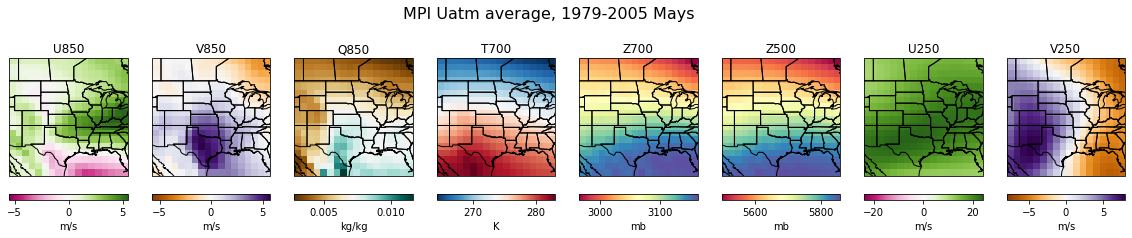

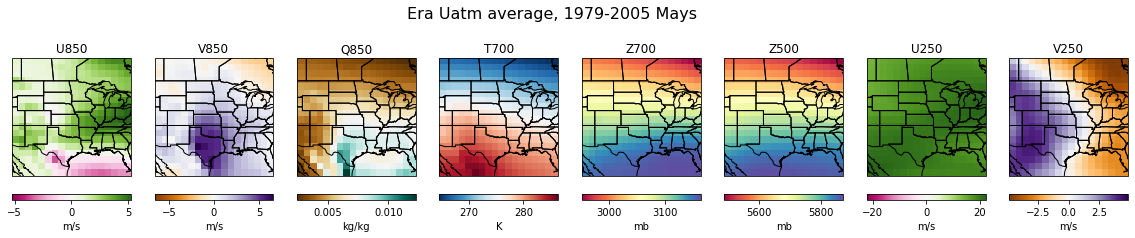

In [18]:
# plot average all hist Mays: MPI & Era
plot_8v_autoscale(allinput, 'MPI Uatm average, 1979-2005 Mays')
plot_8v_autoscale(era_allinput, 'Era Uatm average, 1979-2005 Mays')


# Run over all models

### Hist

In [19]:
# find max/min for each variable accross ALL hist files
#sigfiles_hist = list(filter(lambda line:'hist' in line, mpi_sigfiles))
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


# find min/max values for entire sigfiles set
vmin = 9999*np.ones(8) 
vmax = -9999*np.ones(8) 
for sigfile in sigfiles_hist:   
    
    # skip mpas in max/min range (it's too extreme)
    if sigfile.lower().find('mpas') >= 0: 
        continue
    
    else:
        # load UATM and signal file
        if sigfile.lower().find('obs') >= 0:
            load_uatm_erai()
        elif sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
        rainsignal = xr.open_dataset(sigfile)['prec']

        for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0)]:
            avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal, -9999, 9999) 

            # subtract clim
            #if sigfile.lower().find('obs') >= 0:
            #    avginput-=era_allinput  # era
            #else:
            #    avginput-=allinput  # mpi
            avginput-=era_allinput  # era

            vmin = [min(avginput[ii].min(),vmin[ii]) for ii in range(8)]
            vmax = [max(avginput[ii].max(),vmax[ii]) for ii in range(8)]


Days loaded 13515


In [20]:
#vmin = [-2.860119676676735, -4.102923563004548, -0.0017967277242531702, -2.3120241534937804, -22.72752843471426, -36.628780639855904, -6.612512401846351, -6.854882577848712]
#vmax = [2.0965965940672997, 4.113926477610356, 0.0016094864748026193, 1.5190344257618449, 27.117413894014135, 39.87112130642436, 5.569866144558251, 8.797318717295934]

In [21]:
print(vmin)
print(vmax)

[-3.334549900866702, -4.731989737520342, -0.0018169936349655838, -4.645846719272299, -25.128258966468366, -58.90777320537927, -8.425597959437303, -6.500506919561031]
[2.7420581245563844, 3.802129231571442, 0.0026152846643707397, 1.5190344257618449, 37.54410930299582, 39.87112130642436, 6.604230221923984, 11.092121995915177]


DRY HIST
Days loaded 13515


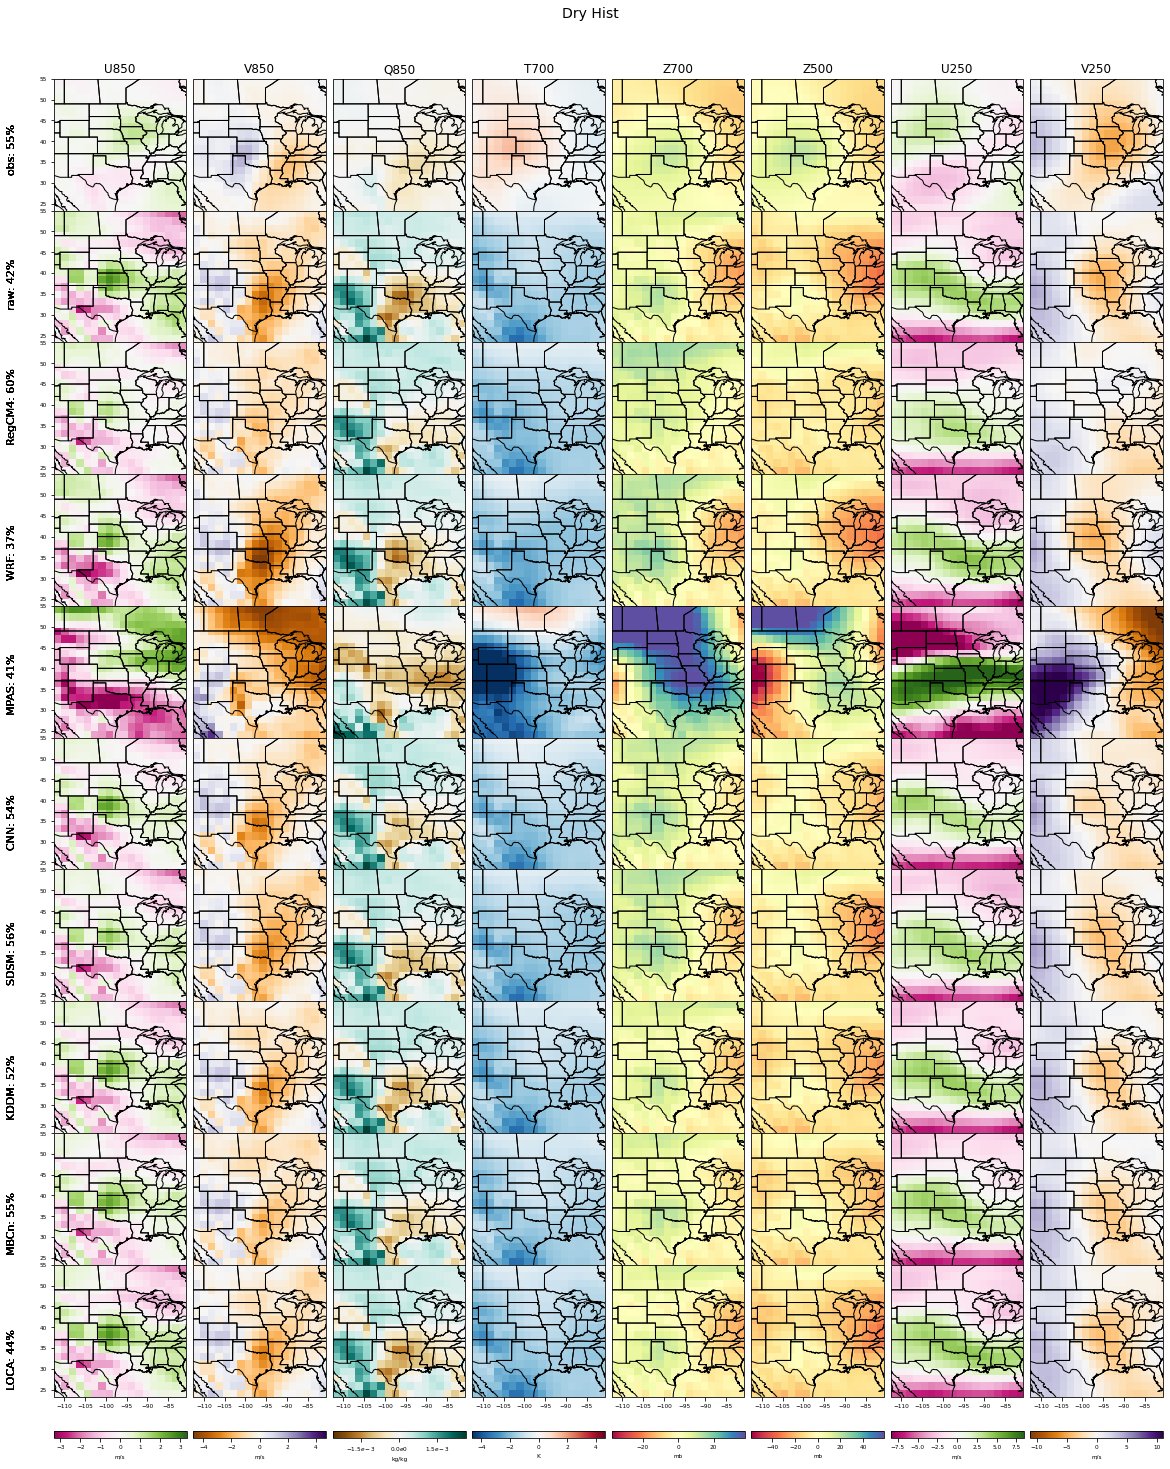

In [22]:
print("DRY HIST")
#sigfiles_hist = list(filter(lambda line:'hist' in line, mpi_sigfiles))
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

plot_models_group_drymoistwet(sigfiles_hist, vmin, vmax, 0, 0.254, "Dry Hist")


MOIST HIST
Days loaded 13515


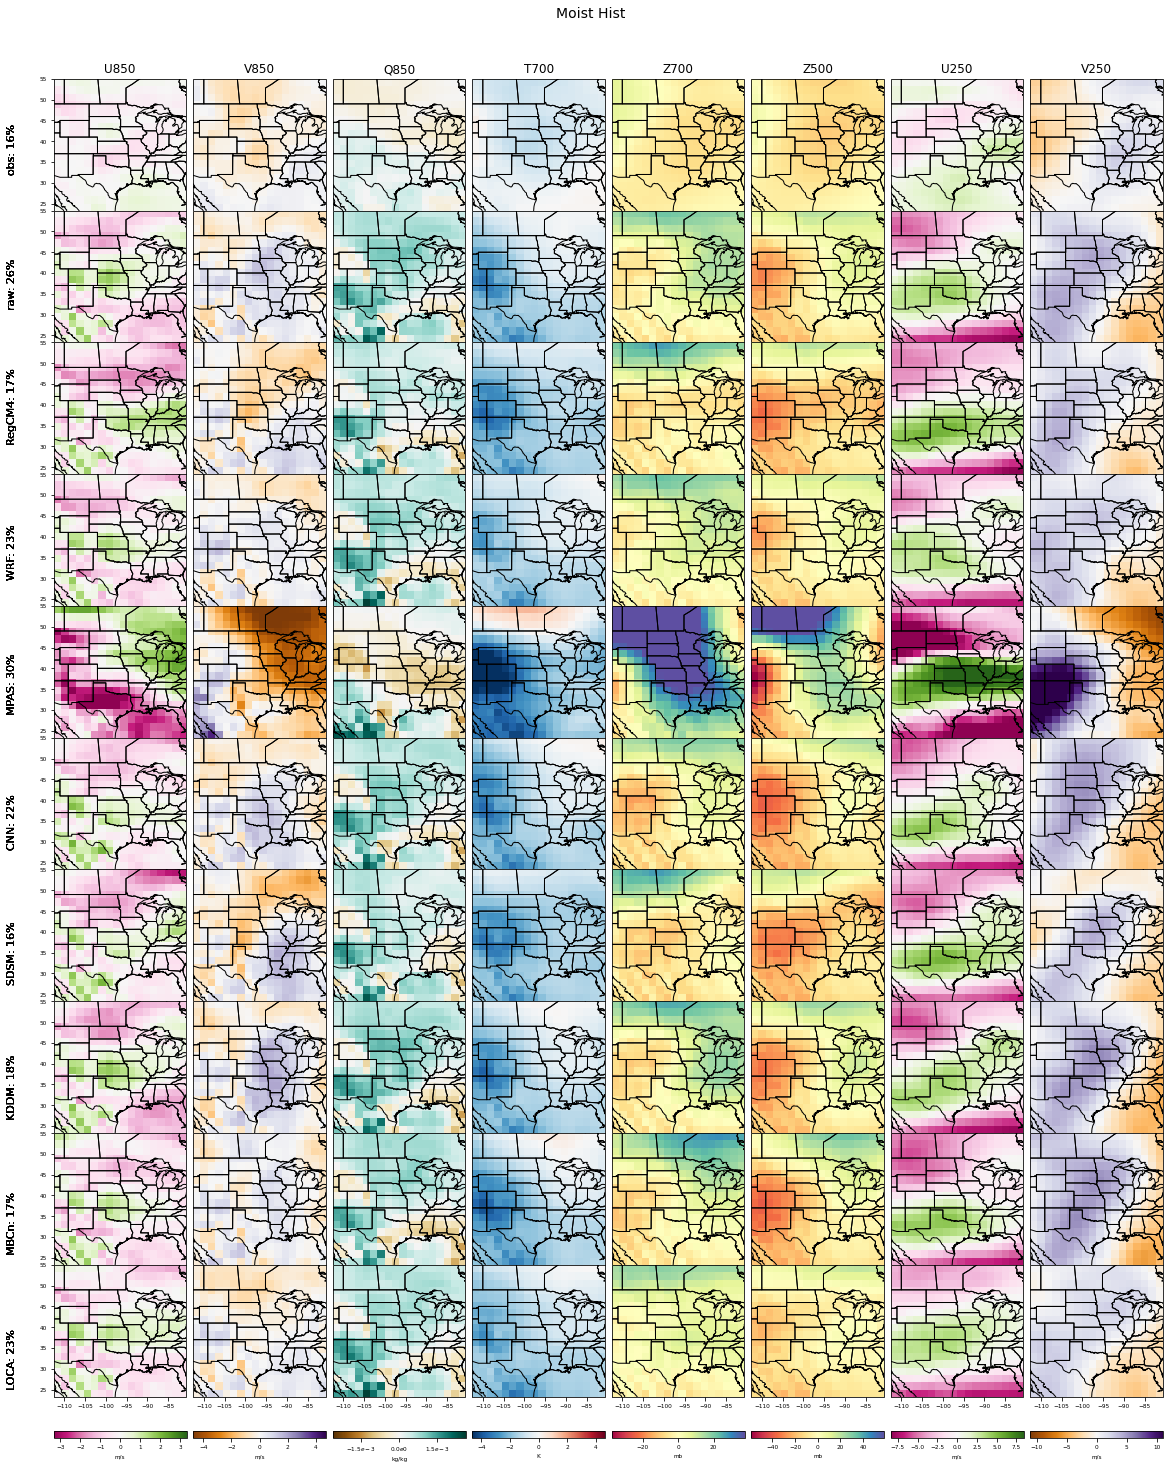

In [23]:
print("MOIST HIST")
#sigfiles_hist = list(filter(lambda line:'hist' in line, mpi_sigfiles))
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

plot_models_group_drymoistwet(sigfiles_hist, vmin, vmax, 0.254, 3., "Moist Hist")


WET HIST
Days loaded 13515


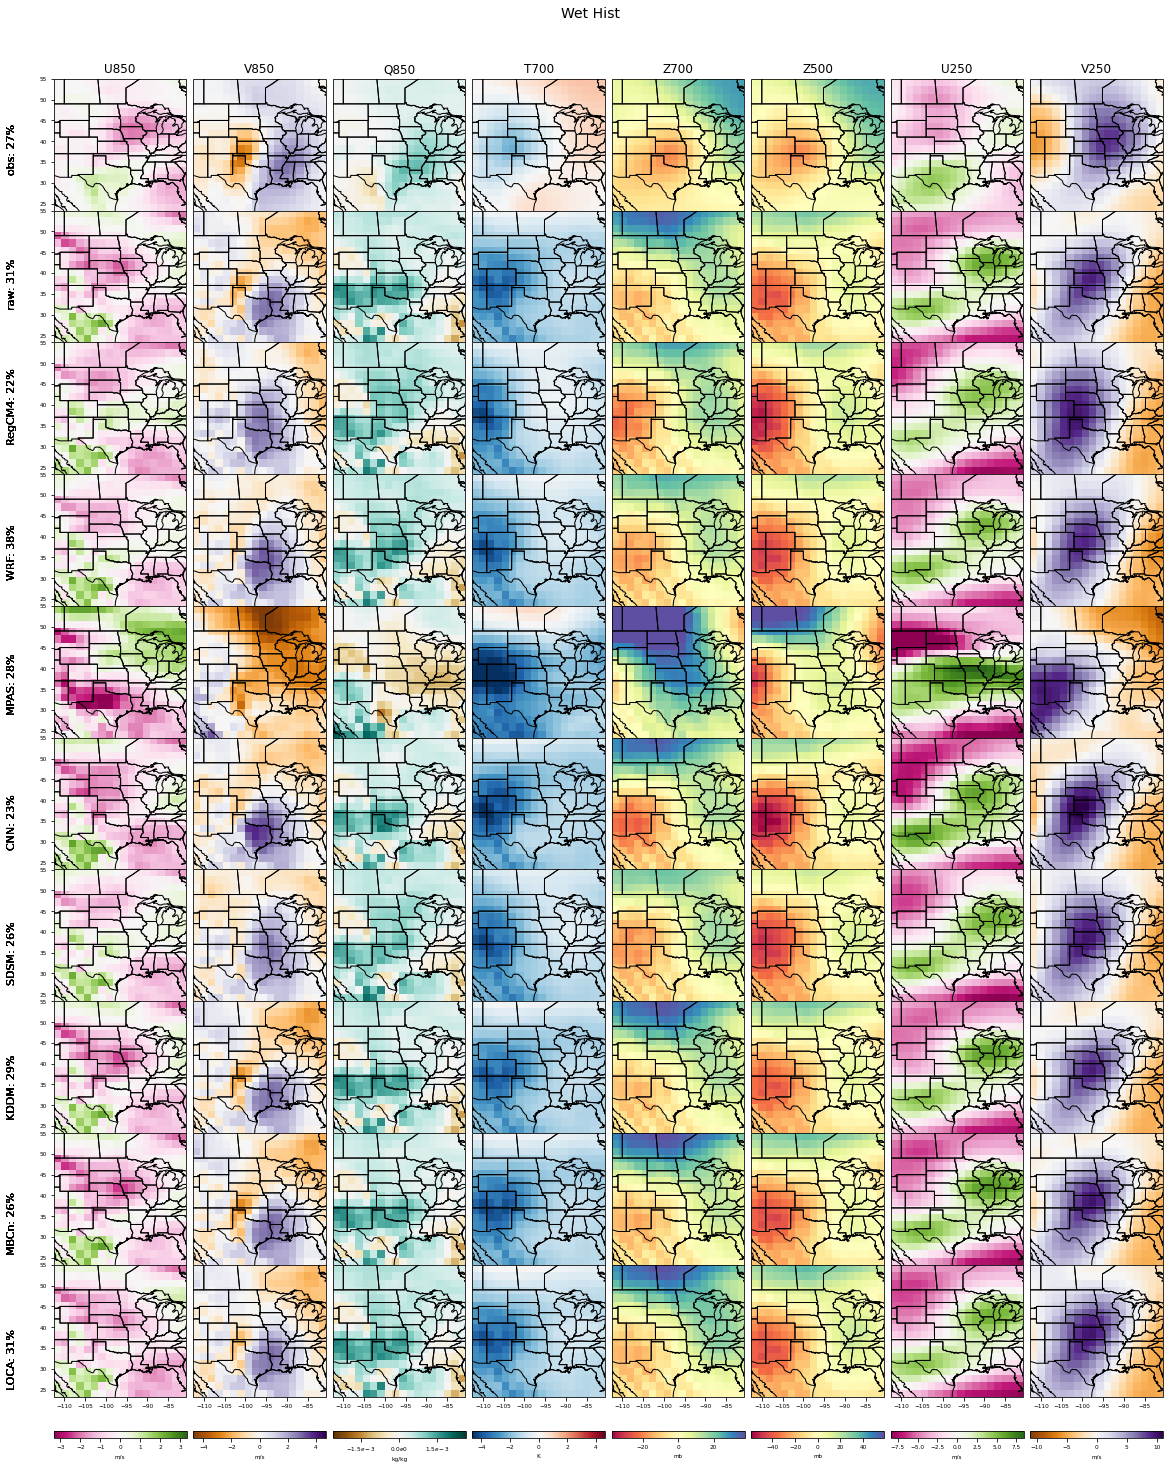

In [24]:
print("WET HIST")
#sigfiles_hist = list(filter(lambda line:'hist' in line, mpi_sigfiles))
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

plot_models_group_drymoistwet(sigfiles_hist, vmin, vmax, 3., 9999, "Wet Hist")


### RCP85

In [25]:
# find max/min for each variable accross ALL rcp85 files
#sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, mpi_sigfiles))
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


# find min/max values for entire sigfiles set
vmin = 9999*np.ones(8) 
vmax = -9999*np.ones(8) 
for sigfile in sigfiles_rcp85:    
    
    # skip mpas in max/min range (it's too extreme)
    if sigfile.lower().find('mpas') >= 0: 
        continue

    else:
        # load UATM and signal file
        if sigfile.lower().find('obs') >= 0:
            load_uatm_erai()
        elif sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
        rainsignal = xr.open_dataset(sigfile)['prec']

        for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0)]:
            avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal, -9999, 9999) 

            # subtract clim
            #if sigfile.lower().find('obs') >= 0:
            #    avginput-=era_allinput  # era
            #else:
            #    avginput-=allinput  # mpi
            avginput-=era_allinput  # era

            vmin = [min(avginput[ii].min(),vmin[ii]) for ii in range(8)]
            vmax = [max(avginput[ii].max(),vmax[ii]) for ii in range(8)]


In [26]:
print(vmin)
print(vmax)

[-3.2245045904822067, -3.4973890920808457, -0.0003601761692733486, -0.2823614509382537, 25.733074345113437, 38.09287926581146, -7.384262475956422, -7.270346787435008]
[3.0835771822507065, 4.629010686121467, 0.0046573674581639095, 4.3280310807199385, 76.71154719209699, 120.45556243445662, 7.878933747574912, 12.027239659158253]


DRY RCP85


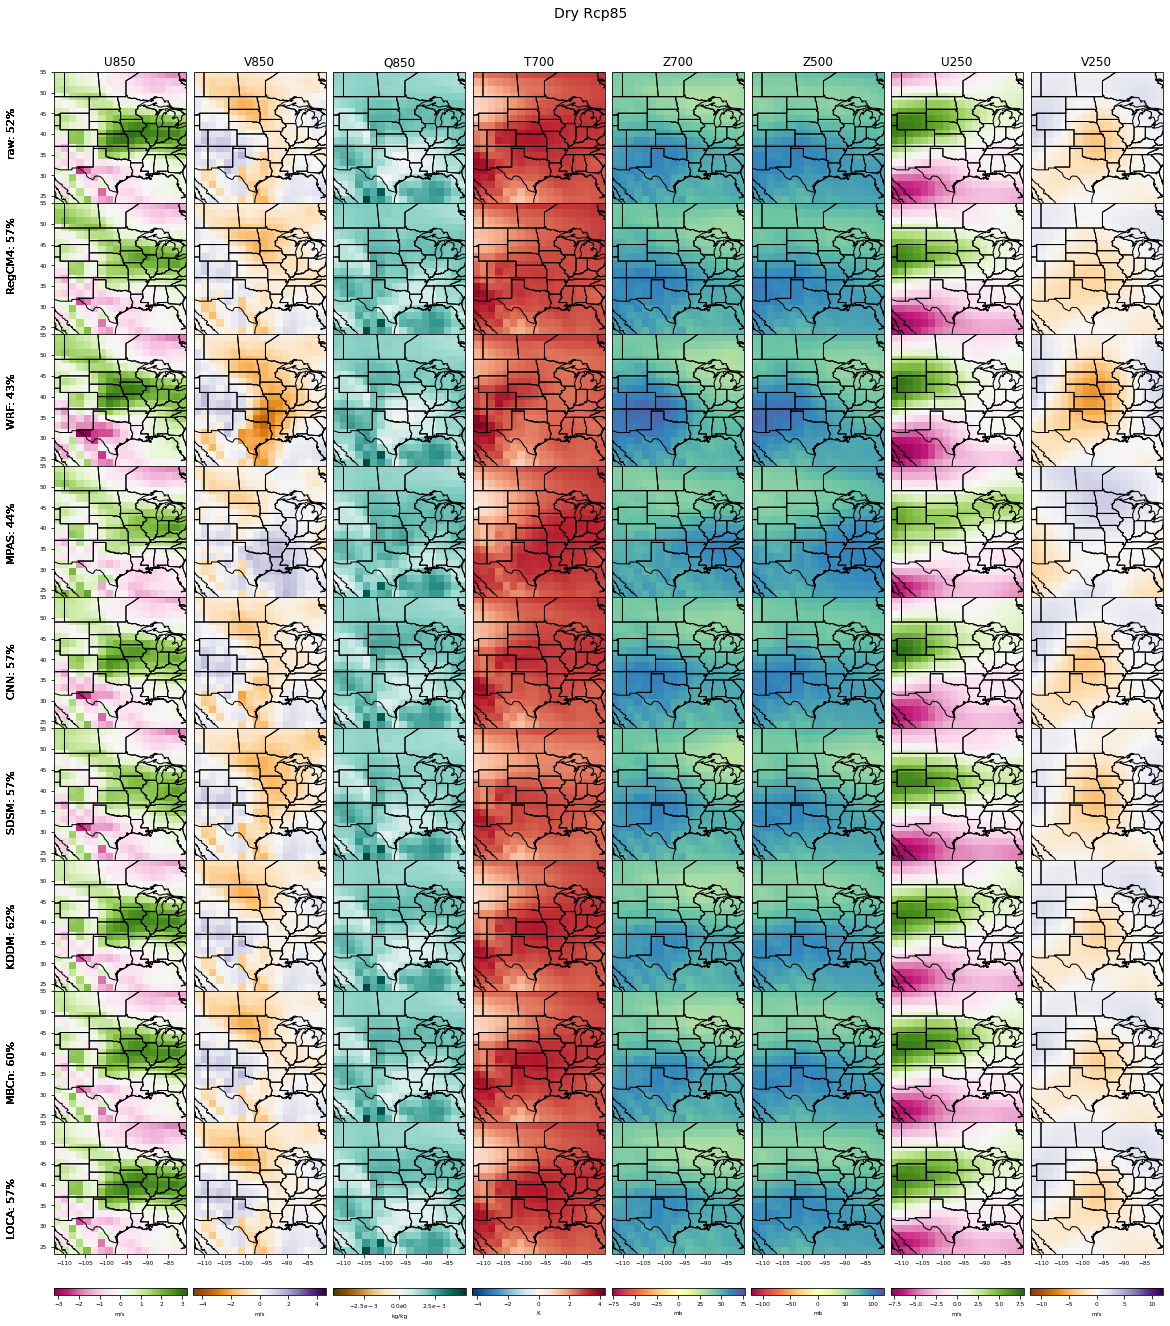

In [27]:
print("DRY RCP85")
#sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, mpi_sigfiles))
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

#plot_models(sigfiles_rcp85)
plot_models_group_drymoistwet(sigfiles_rcp85, vmin, vmax, 0, 0.254, "Dry Rcp85")


MOIST RCP85


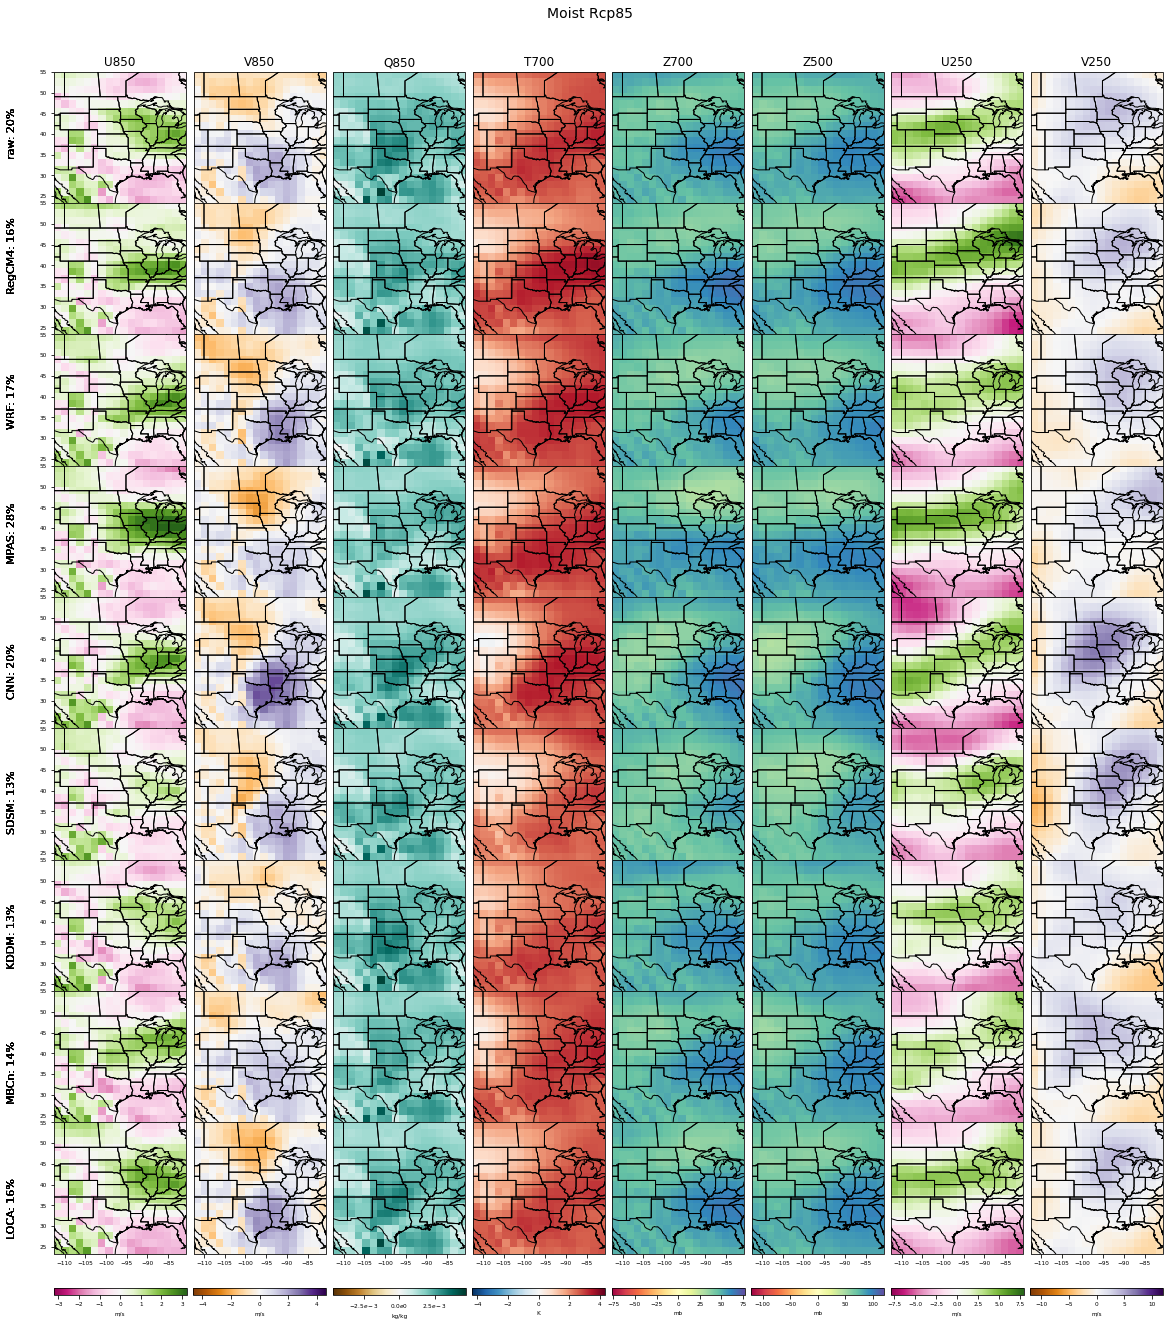

In [28]:
print("MOIST RCP85")
#sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, mpi_sigfiles))
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

plot_models_group_drymoistwet(sigfiles_rcp85, vmin, vmax, 0.254, 3., "Moist Rcp85")


WET RCP85


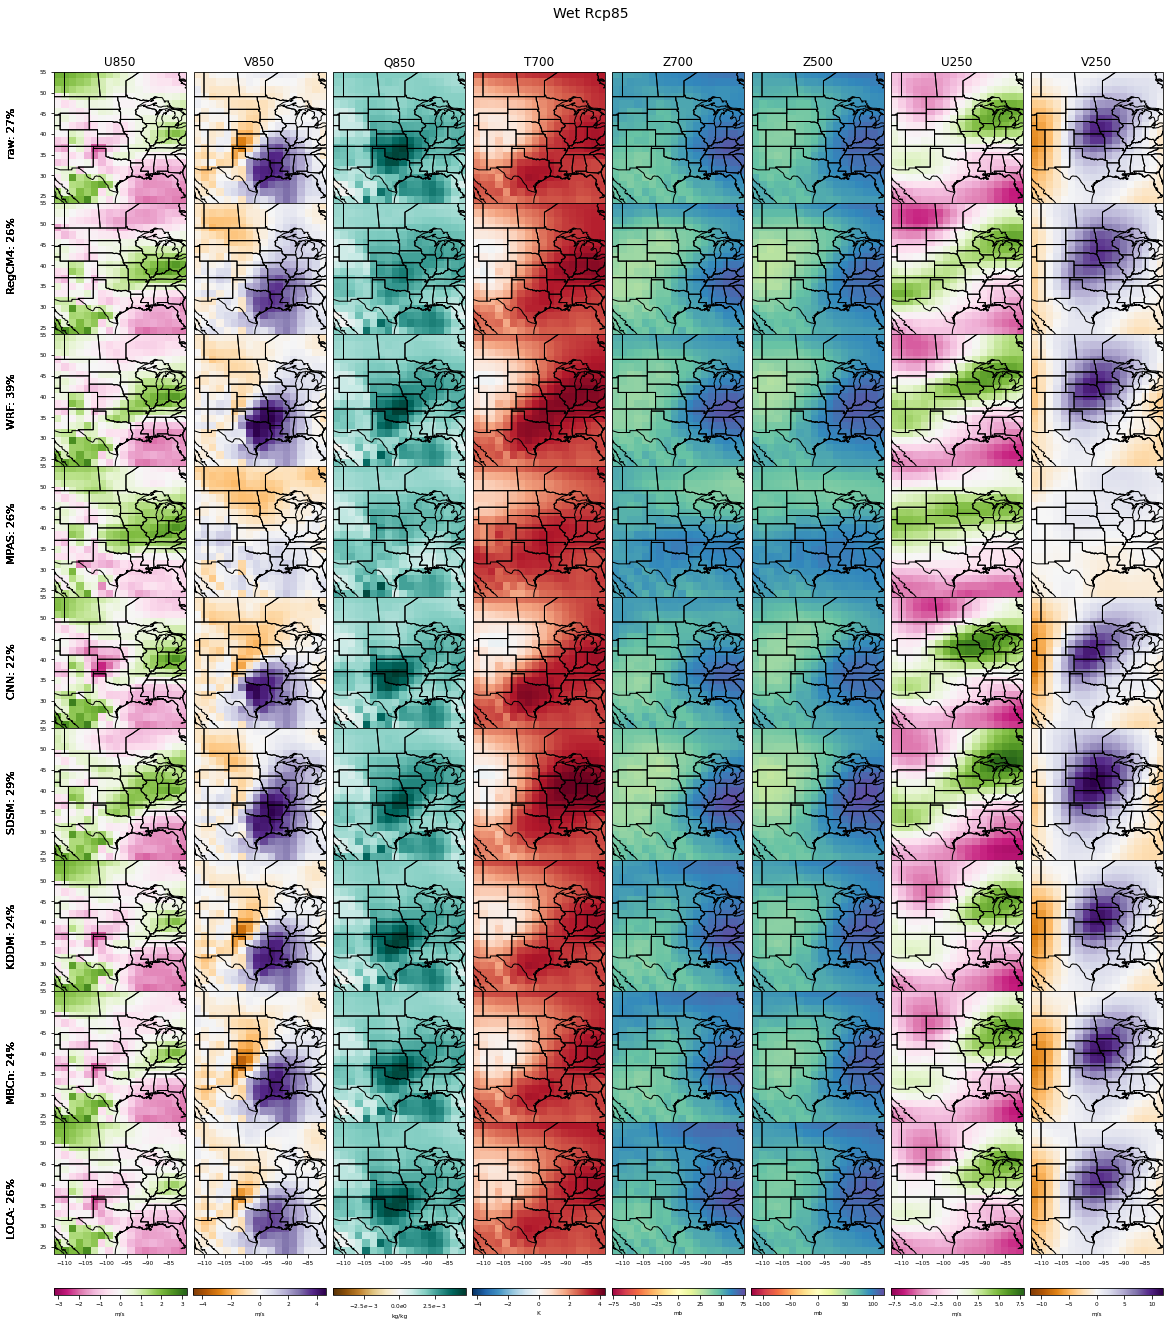

In [29]:
print("WET RCP85")
#sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, mpi_sigfiles))
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

plot_models_group_drymoistwet(sigfiles_rcp85, vmin, vmax, 3., 9999, "Wet Rcp85")


In [ ]:
4